In [2]:
! pip install -q kaggle


In [3]:
! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
%pwd

'/content'

In [4]:
!mv ./kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d rizwan123456789/potato-disease-leaf-datasetpld

 67% 25.0M/37.4M [00:00<00:00, 95.2MB/s]
100% 37.4M/37.4M [00:00<00:00, 122MB/s] 


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('potato-disease-leaf-datasetpld.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()



In [24]:
import os
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc

In [9]:
def show_image(root_folder):
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))
    for i, filename in enumerate(os.listdir(root_folder)):
        folder_path = os.path.join(root_folder, filename)
        files = os.listdir(folder_path)

        for j in range(min(4, len(files))):
            img = plt.imread(os.path.join(folder_path, files[j]))
            axes[i,j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(files[j], fontsize=8, pad=2)


In [10]:
training_path = '/content/PLD_3_Classes_256/Training'
testing_path = '/content/PLD_3_Classes_256/Testing'
validation_path = '/content/PLD_3_Classes_256/Validation'

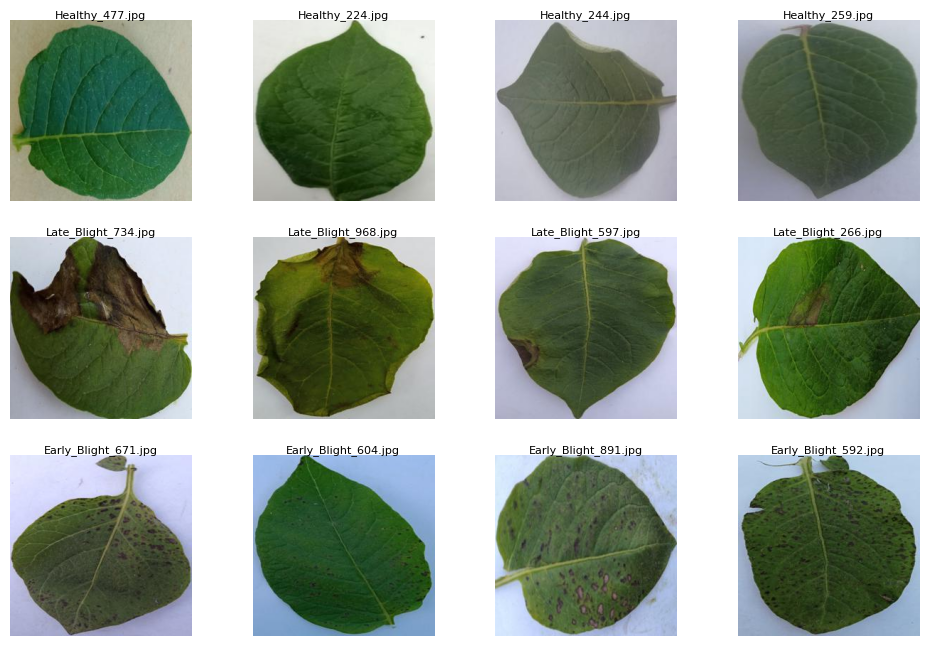

In [11]:
show_image(training_path)

In [12]:
IMAGE_SIZE = 128
BATCH_SIZE = 32

In [13]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=225),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=360),
    transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

def load_and_transform_dataset(data_path, image_size, batch_size, shuffle=True, is_training=True):
    transform = train_transform if is_training else val_test_transform
    dataset = datasets.ImageFolder(root=data_path, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True, prefetch_factor=2) #num_workers allow parallel loading of data, prefetch_factor specifies that 2 batches is being load ahead, pin_memory=speed up processes
    return loader

In [14]:
train_loader = load_and_transform_dataset(training_path, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=True, is_training=True)
val_loader = load_and_transform_dataset(validation_path, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=False, is_training=False)
test_loader = load_and_transform_dataset(testing_path, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=True, is_training=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


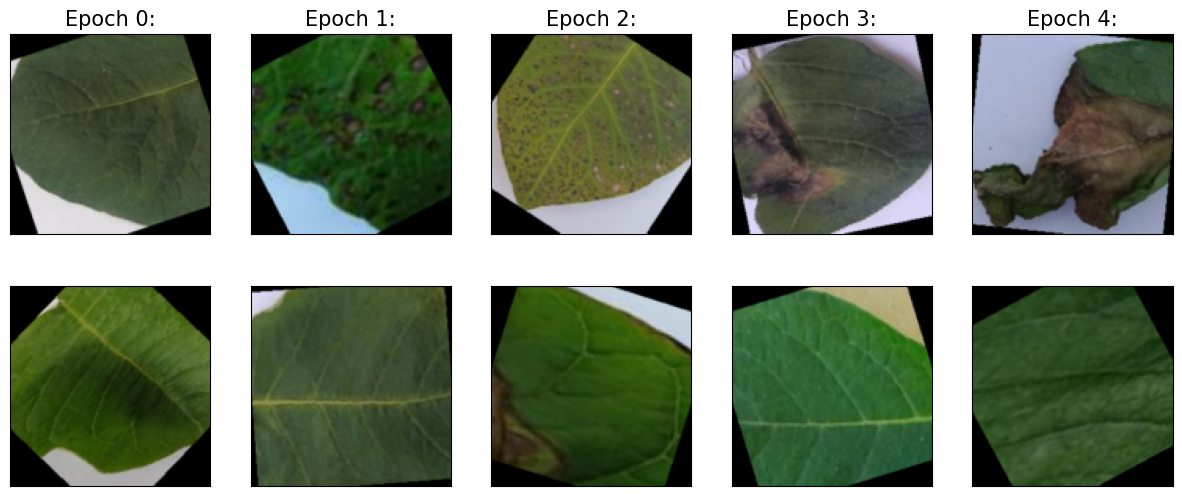

In [15]:
num_epochs = 5
fig = plt.figure(figsize=(15, 6))
for i in range(num_epochs): #for i in range of 5 epoch,
    img_batch, label_batch = next(iter(train_loader)) #gets the next batch of image and their corresponding label
    img = img_batch[0] #extract the first image from the batch
    ax = fig.add_subplot(2, 5, i+1) #extract the first image from the batch
    ax.set_xticks([])  #remove tick marks
    ax.set_yticks([]) #remove tick makrs
    ax.set_title(f'Epoch {i}:', size=15) #title of subpot to indicate what is the epoch number
    ax.imshow(img.permute(1,2,0)) #rearrange the dimension of the image to be shown in imshow - convert tensor from (3,224,224) to (224, 224, 3)

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, i+6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1,2,0))

plt.show()

In [16]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [17]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
#print(x)
#print(output)

Shape before flattening: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 16384]) -> [color_channels, height*width]


In [26]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Calculate the size of the fully connected layer input based on the image dimensions
        self.fc_input_size = 32 * 32 * 32
        # Fully connected layers
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the input for the fully connected layers
        x = x.view(-1, self.fc_input_size)
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
simple_cnn = SimpleCNN()

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_cnn.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = simple_cnn(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print the loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [1/10], Loss: 1.0237071514129639
Epoch [2/10], Loss: 1.152846336364746
Epoch [3/10], Loss: 0.9540436267852783
Epoch [4/10], Loss: 0.6705055236816406
Epoch [5/10], Loss: 0.8135088086128235
Epoch [6/10], Loss: 0.5745583772659302
Epoch [7/10], Loss: 0.6163690090179443
Epoch [8/10], Loss: 0.4196901321411133
Epoch [9/10], Loss: 0.3168719410896301
Epoch [10/10], Loss: 0.681050717830658


In [31]:
model = SimpleCNN()
model.eval()
all_labels = []
all_predictions = []

for inputs, labels in train_loader:
    with torch.no_grad():
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

    all_labels.extend(labels.numpy())
    all_predictions.extend(predictions.numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
f1_value = f1_score(all_labels, all_predictions, average='weighted')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [30]:
# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_value:.4f}")

Accuracy: 0.3457
F1 Score: 0.1848
